In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

from pykitti.tracking import KittiTrackingLabels
from datasets.PyKitti2Dataset import PyKitti2
from hugeica import *
from Mine import *
from hugeica import Adam_Lie
from Crop import crop

import imageio
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import meshplot as mp

from sklearn.neighbors import NearestNeighbors
from AutoCalibration import *

basedir = "/home/ios/data3/kitti/tracking/training"
seq = "0000"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Load Data

files 154


/home/ios/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


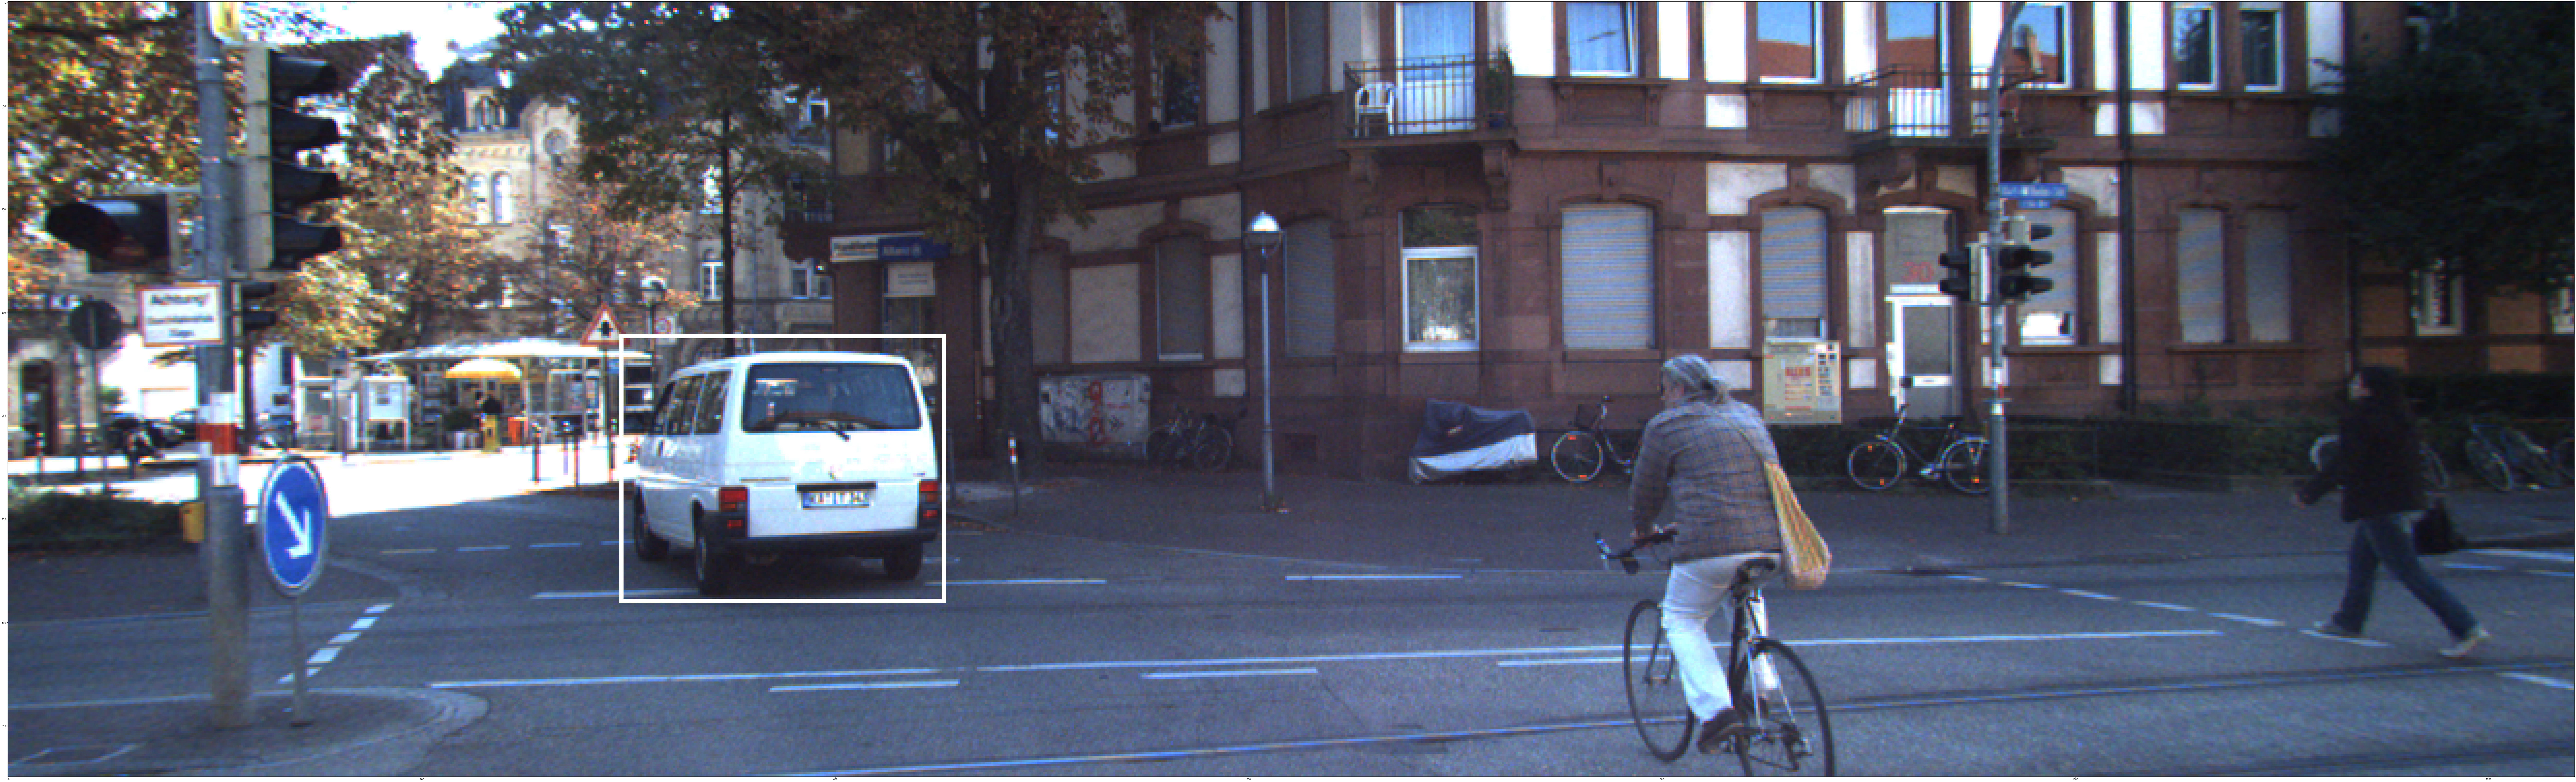

In [3]:
kitti = PyKitti2(basedir, seq, with_labels="box")   

In [4]:
datas = [PyKitti2(basedir, f"{i:04d}", with_labels="none") for i in range(10)]

kitti1 = datas[0]
initRT = kitti1.calib.T_cam2_velo.copy()

files 154
files 447
files 233
files 144
files 314
files 297


/home/ios/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


files 270
files 800
files 390
files 803


In [5]:
# Kitti dataset is recalibrated on different days, so we can just test on sequences that have the same calibration
datas_test1 = [PyKitti2(basedir, f"{i:04d}", with_labels="none") for i in range(10,14)]

files 294
files 373
files 78
files 340


In [6]:
datas_test2 = [PyKitti2(basedir, f"{i:04d}", with_labels="none") for i in range(14,18)]

files 106
files 376
files 209
files 145


In [7]:
datas_test3 = [PyKitti2(basedir, f"{i:04d}", with_labels="none") for i in range(18,20)]

files 339
files 1059


In [8]:
datas_test4 = [PyKitti2(basedir, f"{i:04d}", with_labels="none") for i in range(20,21)]

files 837


In [9]:
datas_test = [datas_test1, datas_test2, datas_test3, datas_test4]

In [10]:
calib0 = datas_test1[0].calib.T_cam2_velo
calib1 = datas_test2[0].calib.T_cam2_velo
calib2 = datas_test3[0].calib.T_cam2_velo
calib3 = datas_test4[0].calib.T_cam2_velo

calib = [calib0, calib1, calib2, calib3]

datas_test

[[PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0010)[294],
  PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0011)[373],
  PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0012)[78],
  PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0013)[340]],
 [PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0014)[106],
  PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0015)[376],
  PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0016)[209],
  PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0017)[145]],
 [PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0018)[314],
  PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0019)[1059]],
 [PyKitti2(base_path=/home/ios/data3/kitti/tracking/training, sequence=0020)[837]]]

# Pretraining

In [14]:
ac = AutoCalibration(kitti1.calib.T_cam2_velo, kitti1.calib.P_rect_20, 
                     patch_size=96, hidden_size=32
                     ,mode="euclidean", rgb_channels=1)
ac.MINE.load_state_dict(torch.load("checkpoints/mi_model_p96_small_2000/MINE_3999.pth.tar"))

ac.to("cuda")

AutoCalibration(
  (R): SO_Layer()
  (T): Linear(in_features=3, out_features=3, bias=True)
  (MINE): Mine(fmaps=32, hidden_size=32, flattened_dim=32, latent_spatial=torch.Size([1, 32, 9, 9]))[259205]
)

In [ ]:
np.random.seed(12)
r = ac.fit(datas, iters=10000, log_interval=100, viz="none", grad_SE=False, grad_mine=True, valid_ratio=0.2, log_avg_window=5, eps=-1)

In [1]:
!ls checkpoints/

checkpoint.pth.tar	     mi_model_p96_small_1000
checkpoint_best_mi.pth.tar   mi_model_p96_small_2000
checkpoint_last.pth.tar      mi_model_p96_small_2000mod
iters			     mi_model_p96_small_25
mi_model_p128_small.pth.tar  mi_model_p96_small_50
mi_model_p32.pth.tar	     mi_model_p96_small_500
mi_model_p48.pth.tar	     mi_model_p96_small_75
mi_model_p64.pth.tar	     mi_model_p96_small_long.pth.tar
mi_model_p64_shift.pth.tar   mi_model_p96_small_registered.pth.tar
mi_model_p68.pth.tar	     mi_model_p96_small_rgb.pth.tar
mi_model_p96.pth.tar	     mi_model_p96_small_rgb_refl.pth.tar
mi_model_p96_small	     seq
mi_model_p96_small.pth.tar   stereo
mi_model_p96_small_100


In [80]:
!mv "checkpoints/checkpoint_best_mi.pth.tar" "checkpoints/mi_model_p96_small_rgb_refl.pth.tar"

In [51]:
ac = AutoCalibration(kitti1.calib.T_cam2_velo, kitti1.calib.P_rect_20, pc_batch=5000, M=20, 
                     patch_size=128, hidden_size=32)

ac.to("cuda")

AutoCalibration(
  (R): SO_Layer()
  (T): Linear(in_features=3, out_features=3, bias=True)
  (MINE): Mine(fmaps=32, hidden_size=32, flattened_dim=32, latent_spatial=torch.Size([1, 32, 17, 17]))[259205]
)

In [52]:
np.random.seed(12)
r = ac.fit(datas, iters=2000, log_interval=10, viz="none", grad_SE=False, valid_ratio=0.2, log_avg_window=5, eps=-1)

#   0: nll: 0.70/0.70, mi: -0.021/-0.008, acc: 50.0/51.0, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
We had to repeat the projection as there where too few projected. 1.0
#  10: nll: 0.70/0.70, mi:  0.002/-0.009, acc: 51.2/51.5, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  20: nll: 0.69/0.70, mi:  0.004/-0.010, acc: 50.0/51.0, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  30: nll: 0.70/0.70, mi: -0.002/-0.010, acc: 48.7/50.5, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  40: nll: 0.70/0.70, mi:  0.000/-0.008, acc: 49.5/50.5, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  50: nll: 0.69/0.70, mi:  0.007/-0.007, acc: 49.5/50.8, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  60: nll: 0.70/0.70, mi: -0.000/-0.004, acc: 49.0/50.9, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  70: nll: 0.70/0.70, mi: -0.008/-0.001, acc: 49.5/51.1, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  80: nll: 0.70/0.70, mi:  0.002/-0.000, acc: 52.

KeyboardInterrupt: 

In [15]:
np.random.seed(12)
r = ac.fit(datas, iters=2000, log_interval=10, viz="none", grad_SE=False, valid_ratio=0.2, log_avg_window=5, eps=-1)

#   0: nll: 0.39/0.53, mi:  1.865/ 1.015, acc: 75.0/75.0, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  10: nll: 0.36/0.54, mi:  1.924/ 0.919, acc: 81.2/73.0, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  20: nll: 0.50/0.54, mi:  1.261/ 0.917, acc: 76.7/73.3, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  30: nll: 0.44/0.54, mi:  1.456/ 0.923, acc: 80.6/73.2, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  40: nll: 0.44/0.53, mi:  1.408/ 0.883, acc: 80.5/73.5, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  50: nll: 0.46/0.54, mi:  1.241/ 0.841, acc: 81.0/73.5, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  60: nll: 0.47/0.52, mi:  1.213/ 0.919, acc: 80.0/75.0, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  70: nll: 0.37/0.52, mi:  1.617/ 0.932, acc: 84.5/74.5, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  80: nll: 0.40/0.52, mi:  1.436/ 0.910, acc: 84.0/73.8, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  90: nll

KeyboardInterrupt: 

In [399]:
np.random.seed(12)
r = ac.fit(datas, iters=6000, log_interval=10, viz="none", grad_SE=False, valid_ratio=0.2, log_avg_window=5, eps=-1)

#   0: nll: 0.70/0.67, mi: -0.001/ 0.099, acc: 53.1/60.6, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
Saved checkpoint
#  10: nll: 0.69/0.68, mi:  0.015/ 0.061, acc: 54.9/56.7, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  20: nll: 0.67/0.67, mi:  0.086/ 0.085, acc: 59.4/58.9, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  30: nll: 0.66/0.67, mi:  0.136/ 0.092, acc: 62.9/59.4, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  40: nll: 0.66/0.67, mi:  0.154/ 0.094, acc: 66.2/59.7, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  50: nll: 0.65/0.68, mi:  0.165/ 0.059, acc: 66.7/55.7, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  60: nll: 0.65/0.68, mi:  0.171/ 0.064, acc: 65.4/55.9, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  70: nll: 0.67/0.69, mi:  0.087/ 0.030, acc: 57.5/52.2, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_cos=0.00
#  80: nll: 0.69/0.69, mi:  0.023/ 0.017, acc: 52.1/52.7, eps: 0.00000, R=[0.0, 0.0, 0.0], t=0.00, Q_co

KeyboardInterrupt: 

In [400]:
torch.save(ac.state_dict(), "checkpoints/mi_model_p128_small.pth.tar")

In [ ]:
np.random.seed(12)
r = ac.fit(datas, iters=10000, log_interval=10, viz="none", grad_SE=False, valid_ratio=0.2, log_avg_window=5)

#   0: nll: 0.69/0.69, mi:  0.007/ 0.017, acc: 0.500/0.517, l2: 0.000, saved checkpoint.
#  10: nll: 0.67/0.69, mi:  0.098/ 0.033, acc: 0.592/0.537, l2: 0.000, saved checkpoint.
#  20: nll: 0.69/0.71, mi: -0.000/-0.056, acc: 0.554/0.496, l2: 0.000
#  30: nll: 0.68/0.70, mi:  0.058/-0.007, acc: 0.567/0.520, l2: 0.000
#  40: nll: 0.71/0.69, mi: -0.072/-0.002, acc: 0.433/0.526, l2: 0.000
#  50: nll: 0.69/0.69, mi:  0.030/ 0.015, acc: 0.558/0.546, l2: 0.000
#  60: nll: 0.68/0.70, mi:  0.037/-0.008, acc: 0.575/0.528, l2: 0.000
#  70: nll: 0.67/0.68, mi:  0.097/ 0.059, acc: 0.633/0.562, l2: 0.000, saved checkpoint.
#  80: nll: 0.66/0.68, mi:  0.148/ 0.053, acc: 0.546/0.568, l2: 0.000
#  90: nll: 0.68/0.68, mi:  0.068/ 0.056, acc: 0.571/0.564, l2: 0.000
# 100: nll: 0.65/0.68, mi:  0.197/ 0.057, acc: 0.696/0.551, l2: 0.000
# 110: nll: 0.69/0.67, mi:  0.045/ 0.080, acc: 0.558/0.568, l2: 0.000, saved checkpoint.
# 120: nll: 0.69/0.67, mi:  0.005/ 0.076, acc: 0.521/0.569, l2: 0.000
# 130: nll: 0.

In [994]:
torch.save(ac.state_dict(), "checkpoints/mi_model_p96_small.pth.tar")

In [230]:
kitti.calib.T_cam2_velo[:3, :3], kitti.calib.T_cam2_velo[:3, 3]

(array([[ 2.34773698e-04, -9.99944155e-01, -1.05634778e-02],
        [ 1.04494074e-02,  1.05653536e-02, -9.99889574e-01],
        [ 9.99945389e-01,  1.24365378e-04,  1.04513030e-02]]),
 array([-0.00279682, -0.07510879, -0.2721328 ]))

In [716]:
(ac.R.weight.data.cpu().numpy() - kitti.calib.T_cam2_velo[:3, :3],
ac.T.bias.data.cpu().numpy() - kitti.calib.T_cam2_velo[:3, 3] )

(array([[ 4.53955271e-12,  4.09591860e-09, -6.27499858e-11],
        [ 2.05625308e-10, -8.39118584e-11,  2.15244176e-08],
        [ 1.35833833e-08,  3.97565065e-12, -1.32011469e-10]]),
 array([6.88625719e-11, 2.47543669e-09, 1.22776841e-08]))